In [1]:
import numpy as np
import scipy.io
import scipy.ndimage.filters
import os
import matplotlib
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
from charSeqLSTM import charSeqLSTM, getDefaultLSTMArgs

#point this towards the top level dataset directory
rootDir = os.path.expanduser('~') + '/handwritingBCIData/'

#train an LSTM using data from these specified sessions
dataDirs = ['t5.2019.05.08','t5.2019.11.25','t5.2019.12.09','t5.2019.12.11','t5.2019.12.18',
            't5.2019.12.20','t5.2020.01.06','t5.2020.01.08','t5.2020.01.13','t5.2020.01.15']

#use this train/test partition 
cvPart = 'HeldOutTrials'

#name of the directory where this LSTM run will be saved
LSTMOutputDir = cvPart

#all LSTM runs are saved in 'Step4_LSTMTraining'
if not os.path.isdir(rootDir + 'LSTMTrainingSteps/Step4_LSTMTraining'):
    os.mkdir(rootDir + 'LSTMTrainingSteps/Step4_LSTMTraining')
    

In [2]:
#We will use the default arguments specified here
args = getDefaultLSTMArgs()

#Configure the arguments for a multi-day LSTM (that will have a unique input layer for each day)
for x in range(len(dataDirs)):
    args['sentencesFile_'+str(x)] = rootDir+'Datasets/'+dataDirs[x]+'/sentences.mat'
    args['singleLettersFile_'+str(x)] = rootDir+'Datasets/'+dataDirs[x]+'/singleLetters.mat'
    args['labelsFile_'+str(x)] = rootDir+'LSTMTrainingSteps/Step2_HMMLabels/'+cvPart+'/'+dataDirs[x]+'_timeSeriesLabels.mat'
    args['syntheticDatasetDir_'+str(x)] = rootDir+'LSTMTrainingSteps/Step3_SyntheticSentences/'+cvPart+'/'+dataDirs[x]+'_syntheticSentences/'
    args['cvPartitionFile_'+str(x)] = rootDir+'LSTMTrainingSteps/trainTestPartitions_'+cvPart+'.mat'
    args['sessionName_'+str(x)] = dataDirs[x]
    
args['outputDir'] = rootDir+'LSTMTrainingSteps/Step4_LSTMTraining/'+LSTMOutputDir
if not os.path.isdir(args['outputDir']):
    os.mkdir(args['outputDir'])
    
#this weights each day equally (0.1 probability for each day) and allocates a unique input layer for each day (0-9)
args['dayProbability'] = '[0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]'
args['dayToLayerMap'] = '[0,1,2,3,4,5,6,7,8,9]'

#save the arguments dictionary so that the LSTM program can load it
pickle.dump( args, open( args['outputDir'] + '/args.p', "wb" ) )

In [3]:
#The following code snippet will launch an LSTM training program in a separate python kernel (so it doesn't launch inside
#the jupyter notebook, which can be unstable).
import os
argsFile = args['outputDir'] + '/args.p'
scriptFile = os.getcwd()+'/charSeqLSTM.py'
os.system('python3 ' + scriptFile + ' --argsFile=' + argsFile + ' &')


0

now snapshot
{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Fri Jan  8 05:56:43 2021', '__version__': '1.0', '__globals__': [], 'inputs': array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.14177264,  0.36482576, -0.2797799 , ..., -0.31784922,
        -0.16255547, -0.6958288 ],
       [-0.0630504 ,  0.3478005 , -0.20780575, ..., -0.2704961 ,
        -0.135195  , -0.638541  ],
       [ 0.04552032,  0.26737186, -0.13033529, ..., -0.22304273,
        -0.12357451, -0.51903003]], dtype=float32), 'rnnUnits': array([[-0.07194206, -0.10187339, -0.13351323, ...,  0.1296325 ,
         0.02484634, -0.03252753],
       [-0.10931176, -0.22116715, -0.2868932 , ...,  0.18150492,
         0.03614668, -0.06549539],
  

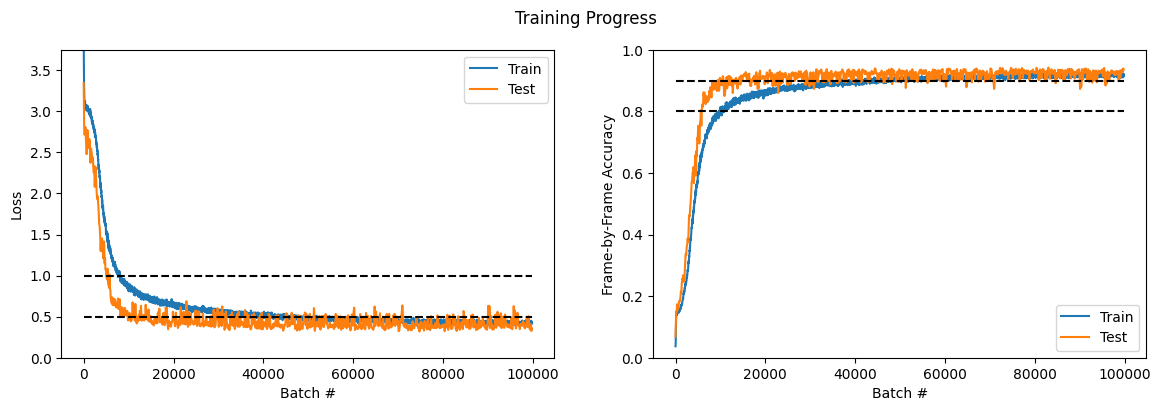

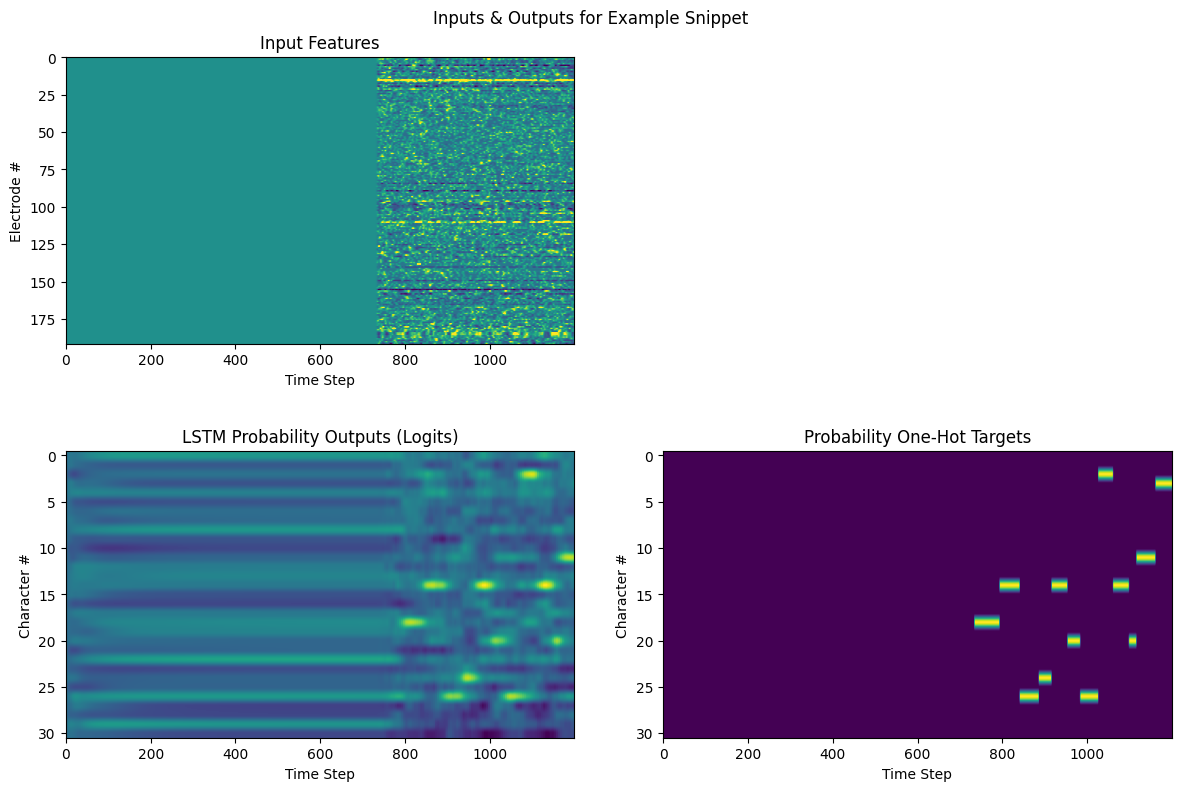

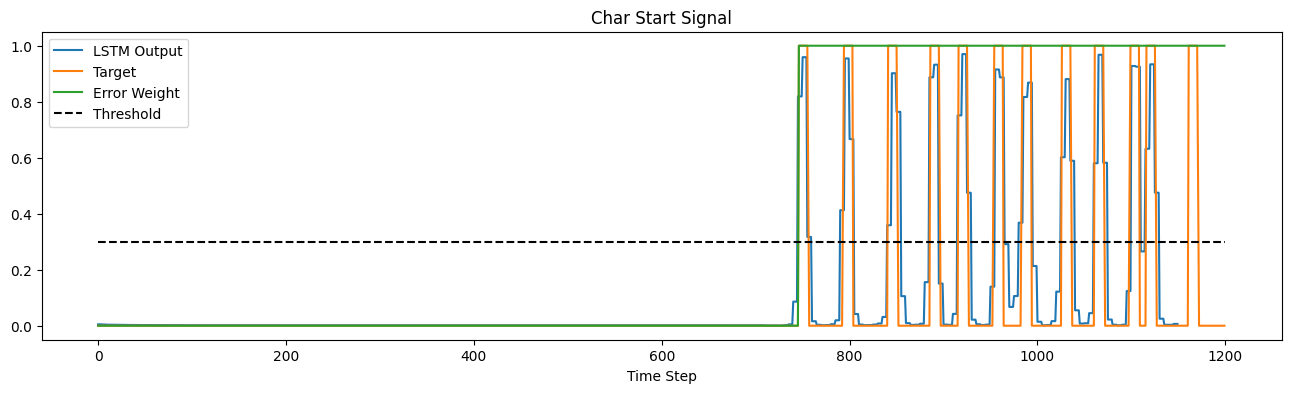

In [4]:
#Run this cell to visualize the training process in real-time. You can stop it at any time without interrupting the
#training.
import time
from IPython import display
from scipy.ndimage.filters import gaussian_filter1d

while True:
    #The LSTM training process periodically saves off performance statistics and a snapshot of LSTM outputs, which we load here.
    try:
        snapshot = scipy.io.loadmat(args['outputDir'] + '/outputSnapshot.mat')
        intOut = scipy.io.loadmat(args['outputDir'] + '/intermediateOutput.mat')
      
    except:
        time.sleep(30)
        continue
    
    display.clear_output(wait=True)

    plotEnd = np.argwhere(intOut['batchTrainStats'][:,0]==0)
    plotEnd = plotEnd[1][0]-1
    
    plotEndVal = np.argwhere(intOut['batchValStats'][:,0]==0)
    plotEndVal = plotEndVal[1][0]-1
    print("now snapshot")
    print(snapshot)
    print("keys snapshot")
    print(snapshot.keys())
    print("intOut")
    print(intOut)

    #----Training loss & frame-by-frame accuracy----
    plt.figure(figsize=(14,4))
    plt.subplot(1,2,1)
    plt.plot(intOut['batchTrainStats'][0:plotEnd,0], gaussian_filter1d(intOut['batchTrainStats'][0:plotEnd,1], 10))
    plt.plot(intOut['batchValStats'][0:plotEndVal,0], gaussian_filter1d(intOut['batchValStats'][0:plotEndVal,1], 1))
    plt.plot([0, intOut['batchValStats'][plotEndVal,0]], [0.50, 0.50],'--k') #guidelines for visualization
    plt.plot([0, intOut['batchValStats'][plotEndVal,0]], [1.0, 1.0],'--k')
    plt.xlabel('Batch #')
    plt.legend(['Train','Test'])
    plt.ylim([0,3.75])
    plt.ylabel('Loss')
    
    plt.subplot(1,2,2)
    plt.plot(intOut['batchTrainStats'][0:plotEnd,0], gaussian_filter1d(intOut['batchTrainStats'][0:plotEnd,3], 10))
    plt.plot(intOut['batchValStats'][0:plotEndVal,0], gaussian_filter1d(intOut['batchValStats'][0:plotEndVal,3], 1))
    plt.plot([0, intOut['batchValStats'][plotEndVal,0]], [0.8, 0.8],'--k') #guidelines for visualization
    plt.plot([0, intOut['batchValStats'][plotEndVal,0]], [0.9, 0.9],'--k')
    plt.ylim([0,1.0])
    plt.xlabel('Batch #')
    plt.legend(['Train','Test'])
    plt.ylabel('Frame-by-Frame Accuracy')
    
    plt.suptitle('Training Progress')

    display.display(plt.gcf())
    plt.close()
        
    #----LSTM outputs & training targets----
    plt.figure(figsize=(12.45, 8.3))
    plt.subplot(2,2,1)
    plt.imshow(np.transpose(snapshot['inputs']),aspect='auto',clim=[-1,1])
    plt.title('Input Features')
    plt.ylabel('Electrode #')
    plt.xlabel('Time Step')

    

    plt.subplot(2,2,3)
    plt.imshow(np.transpose(snapshot['charProbOutput']),aspect='auto')
    plt.title('LSTM Probability Outputs (Logits)')
    plt.ylabel('Character #')
    plt.xlabel('Time Step')

    plt.subplot(2,2,4)
    plt.imshow(np.transpose(snapshot['charProbTarget']),aspect='auto')
    plt.title('Probability One-Hot Targets')
    plt.ylabel('Character #')
    plt.xlabel('Time Step')

    plt.tight_layout(pad=3)
    plt.suptitle('Inputs & Outputs for Example Snippet')
    display.display(plt.gcf())
    plt.close()

    plt.figure(figsize=(16,4))
    plt.plot(np.squeeze(snapshot['charStartOutput']))
    plt.plot(np.squeeze(snapshot['charStartTarget']))
    plt.plot(np.squeeze(snapshot['errorWeight']))
    plt.plot([0,snapshot['errorWeight'].shape[1]],[0.3,0.3],'--k')
    plt.title('Char Start Signal')
    plt.xlabel('Time Step')
    plt.legend(['LSTM Output','Target','Error Weight','Threshold'])
    
    display.display(plt.gcf())
    plt.close()
    
    time.sleep(30)